In [646]:
cd 'C:\Users\barry\Documents\Academics\Quantecon-Notes'
addpath('C:\Users\barry\Documents\Academics\Quantecon-Notes\functions')

# Value Function Iteration

In this notebook we solve a simple stochastic growth problem using value function iteration. The model is based on NYU course Quantitative Macroeconomics by Gianluca Violante

## Model setup
Consider the planner's problem

$$
V(k,z) = \max_{c,k',h} u(c) + v(1-h) + \beta\sum_{z'\in Z}\pi(z,z')V(k',z')\\
u(c) = \frac{c^{1-\gamma}}{1-\gamma}\\
v(1-h) = \log(1-h)\\
c+k' = e^z k^\alpha h^{1-\alpha} + (1-\delta)k\\
c \geq 0 \\
k' \geq 0\\
h\in [0,1]\\
z_{t+1} = \rho z_t + \epsilon_{t+1}
$$

We want to solve for the policy functions $g_c(z,k), g_k(z,k), g_h(z,k)$. We do it by value function iteration and discretizatoin of the state space $(Z,K)$

Parameters: $\alpha = 0.2, \beta = 0.9, \delta = 0.1, \theta = 0.5, \gamma = 2, \eta = 2.5,\rho = 0.6, \sigma=0.1$
### Step1: solve for Steady State
Since $z$ is of mean 0, at steady state $z = 0$ and $k' = k$, so 

Euler equation:
$$
f_k(k^*, 1-h^*) = \alpha k^{\alpha-1}h^{1-\alpha} = (\frac{1}{\beta} -1+\delta)
$$
Intratemporal choice:
$$
\frac{\partial [u(c) + v(1-h) - \lambda (k^\alpha h^{1-\alpha} - c - \delta k)]}{\partial c} = 0,
\frac{\partial [u(c) + v(1-h) - \lambda (k^\alpha h^{1-\alpha} - c - \delta k)]}{\partial h} = 0 \\
\Rightarrow c^{-\gamma}(1-\alpha)k^\alpha h^{-\alpha} = \frac{1}{1-h}
$$
Resource constraint:
$$
c^* + \delta k^* = {k^*}^\alpha{h^*}^{1-\alpha}
$$

Three equations with three unknowns

In [895]:
alpha = 0.2; 
beta = 0.9;
delta = 0.1;
gamma = 2;
rho = 0.6;

syms kstar cstar hstar
eqns = [alpha*kstar^(alpha - 1)*hstar^(1-alpha) - (1/beta-1+delta)==0,
        cstar^(-gamma)*(1-alpha)*kstar^alpha*hstar^(-alpha) == 1/(1-hstar),
        cstar+delta*kstar == kstar^alpha*hstar^(1-alpha)];
sol = vpasolve(eqns, [kstar cstar hstar],[0.1 0.1 0.1]);
kstar = double(sol.kstar)
cstar = double(sol.cstar)
hstar = double(sol.hstar)


kstar =

    0.5760


cstar =

    0.5504


hstar =

    0.6162




### Step2: set up grid for $k$ and $z$

Approximate the AR(1) process using Tauchen method

In [896]:
k = linspace(0.01,1,30);
[z, t_matrix] = Tauchen(10, 0.6, 0.1);

s = meshgrid(k,k,z);
size(s)


ans =

    30    30    10




Solve with the choice of leisure:

At every $(k_i,k_j,z_s)$ corresponding to variable $(k,k',z)$, we have intratemporal FOC:
$$
\frac{d u(e^zk^\alpha h^{1-\alpha} + (1-\delta)k-k')}{dh} + \frac{dv(1-h)}{dh} = 0 \\
\Rightarrow \frac{1}{1-h} = (e^zk^\alpha h^{1-\alpha} + (1-\delta)k-k')^{-\gamma}(1-\alpha)e^zk^\alpha h^{-\alpha}
$$

Solve for $h(k_i,k_j,z_s)$

In [897]:
%%file functions\VFI_h.m
function out = VFI_h(x,z,ki,kj,alpha,delta,gamma)
    out = 1/(1-x)*(exp(z)*ki^alpha*x^(1-alpha)+(1-delta)*ki - kj)^gamma-(1-alpha)*exp(z)*ki^alpha*x^(-alpha);

Created file 'C:\Users\barry\Documents\Academics\Quantecon-Notes\functions\VFI_h.m'.


In [953]:
h = zeros(size(s));
val_store = zeros(size(s));
tol = 1e-6;
for i = 1:size(s,1)
    for j = 1:size(s,2)
        for m = 1:size(s,3)
            syms x 
            %eqn = [theta*(1-x)*(1-alpha)*exp(z(m))*k(i)^(alpha)*x^(-alpha) ...
            %== (1-theta)*(exp(z(m))*k(i)^alpha*x^(1-alpha)+(1-delta)*k(i) - k(j))];
            %eqn = (1-theta)*((1-delta)*k(i) - k(j)) + exp(z(m))*k(i)^alpha*x^(-alpha)*(x-theta) == 0;
            %eqn = 1/(1-x)*(exp(z(m))*k(i)^alpha*x^(1-alpha)+(1-delta)*k(i) - k(j))^gamma ...
            % -(1-alpha)*exp(z(m))*k(i)^alpha*x^(-alpha)==0;
            % sol = vpasolve(eqn, x,[0 1]);
            f = @(x)VFI_h(x,z(m),k(i),k(j),alpha,delta, gamma);
            options = optimset('Display','off');
            [x,val] = fsolve(f,0.5, options);
             if x<0 || x > 1 || imag(x) ~= 0
                 [x,val] = fsolve(f,0.01,options);
             end
             if x<0 || x > 1 || imag(x) ~= 0
                 [x,val] = fsolve(f,0.99,options);
             end
             if x<0 || x > 1 || imag(x) ~= 0
                 [x,val] = fsolve(f,0.999,options);
             end
             if x<0 || x > 1 || imag(x) ~= 0
                 [x,val] = fsolve(f,0.001,options);
             end
             
             if x<0 || x > 1 || imag(x) ~= 0
                 [x,val] = fsolve(f,0.9999,options);
             end
             if x<0 || x > 1 || imag(x) ~= 0
                 [x,val] = fsolve(f,0.0001,options);
             end
            h(i,j,m) = x;
            val_store(i,j,m) = abs(val) > tol;
        end

    end
end
    

### Step3: Solution algorithm

1. Define a three dimensoinal array $R$ of size $(N,N,S)$ for the return function
$$
R(k_i,k_j,z_s) = u(e^zk_i^\alpha h(k_i,k_j,z_s)^{1-\alpha} + (1-\delta)k_i-k_j,(1-h(k_i,k_j,z_s)))
$$
Check whether the argument of $u$ at point $(i,j,s)$is negative: if so, set $R(k_i,k_j,z_s)$ to a very large negative value. 
2. Start with a guess of the $(N,S)$ matrix $V^0$, say 
$$
V^0(k_i,z_s) = \frac{u(e^zk_i^\alpha {h^*}^{1-\alpha} -\delta k_i,1-h^*)}{1-\beta}
$$
3. At each iteration $t$, compute the $(N,S)$ matrix $V^t$ that represents the conditional expected value with generic element
$$
\mathbb{V}^t(k_j,z_s) = \sum_{s'=1}^S\pi(z_s,z_{s'})V^t(k_j,z_{s'})
$$
4. Update value function by selecting 
$$
V^{t+1}(k_i,z_s) = \max_j R(k_i,k_j,z_s) + \beta \mathbb{V}^t(k_j,z_s)
$$
5. Store the argmax
$$
g_k^{t+1}(k_i,z_s) = \arg\max_j R(k_i,k_j,z_s) + \beta \mathbb{V}^t(k_j,z_s)\\
g_h^{t+1}(k_i,z_s) = h(k_i,g_k^{t+1}(k_i,z_s),z_s)\\
g_c^{t+1}(k_i,z_s) = e^{z_s} k_i^\alpha {g_h^{t+1}}^{1-\alpha} + (1-\delta)k_i - g_k^{t+1}(k_i,z_s)
$$

In [958]:
C = zeros(size(s));
R = zeros(size(s));
for i = 1:size(s,1)
    for j = 1:size(s,2)
        for m = 1:size(s,3)
        if exp(z(m))*k(i)^alpha*h(i,j,m)^(1-alpha) + (1-delta)*k(i)-k(j) < 0 || h(i,j,m) <0 ||h(i,j,m) >= 1
            R(i,j,m) = -Inf;
        else
            R(i,j,m) = (exp(z(m))*k(i)^alpha*h(i,j,m)^(1-alpha) + (1-delta)*k(i)...
            -k(j))^(1-gamma)/(1-gamma) + log(1-h(i,j,m));
        end
        C(i,j,m) = exp(z(m))*k(i)^alpha*h(i,j,m)^(1-alpha) + (1-delta)*k(i)-k(j);
        end
    end
end
%R = real(R);

V_0 = meshgrid(z,k);

for i = 1:size(s,1)
    for m = 1:size(s,3)
    V_0(i,m) = (((exp(z(m))*k(i)^alpha*hstar^(1-alpha) -delta*k(i))^theta...
    *(1-hstar)^(1-theta))^(1-gamma)/(1-gamma))/(1-beta);
    end
end

V = real(V_0);

maxit = 1000;
eps = 1e-7;

for count = 1:maxit
    V_prime = V*t_matrix';
    temp = zeros(size(R));
    for j = 1:size(R,1)
        temp(j,:,:) = R(j,:,:) + reshape(beta*V_prime,1,size(V_prime,1),size(V_prime,2));
    end
    [argvalue, argmax]= max(temp,[],2);
    V_new = squeeze(argvalue);
    

    optimal_choice = squeeze(argmax);
    g_k = squeeze(k(argmax));
    
    g_h = zeros(size(g_k));
    for i = 1:size(g_h,1)
        for m = 1:size(g_h,2)
            g_h(i,m) = h(i,optimal_choice(i,m),m);
        end
    end
    
    g_c = zeros(size(g_h));
    for i = 1:size(s,1)
        for m = 1:size(s,3)
            g_c(i,m) = exp(z(m))*(k(i)^alpha)*g_h(i,m)^(1-alpha) +(1-delta)*k(i) - g_k(i,m);
        end
    end

    if max(max(abs(V-V_new))) < eps
        X = sprintf('Converged after iteration %d', count);
        disp(X)
        break
    end
    V = V_new;
end

Converged after iteration 145



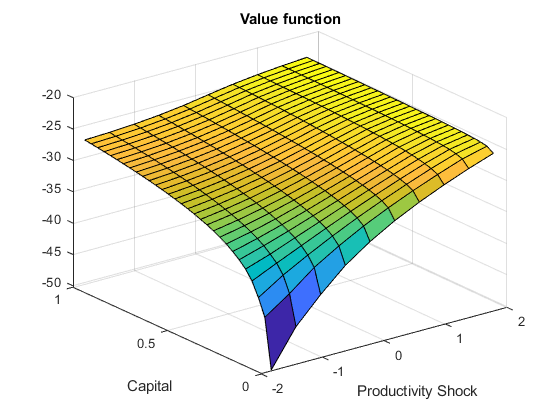

In [966]:
surf(z,k,V)
title('Value function')
xlabel('Productivity Shock')
ylabel('Capital')

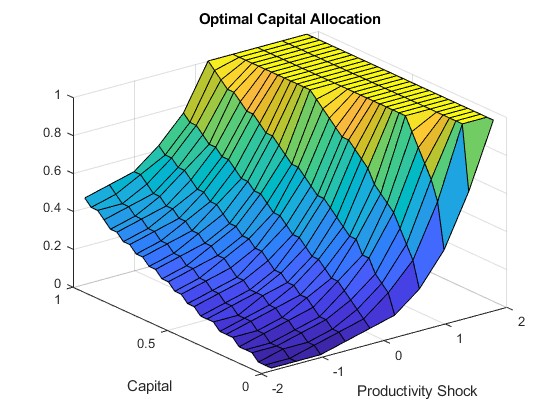

In [967]:
surf(z,k,g_k)
title('Optimal Capital Allocation')
xlabel('Productivity Shock')
ylabel('Capital')

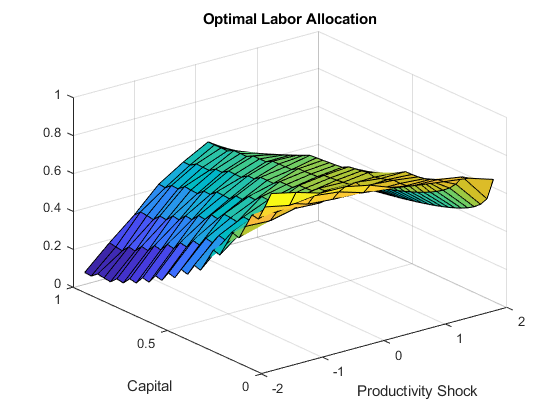

In [969]:
surf(z,k,g_h)
title('Optimal Labor Allocation')
xlabel('Productivity Shock')
ylabel('Capital')

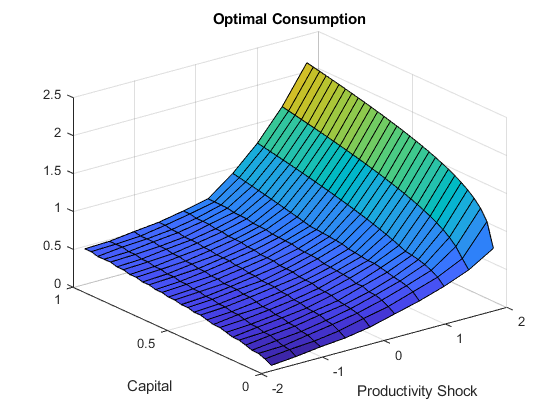

In [971]:
surf(z,k,g_c)
title('Optimal Consumption')
xlabel('Productivity Shock')
ylabel('Capital')